In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
from scipy.stats import ttest_ind
import scipy.stats as ss


#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge spacy

In [3]:
#importing the dataset
train=pd.read_csv("/home/deng_bobby/w266-data/train.csv")
test=pd.read_csv("/home/deng_bobby/w266-data/test.csv")

In [4]:
#take a peak
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [5]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


There is a 30:70 train: test split and the test set might change in the future too.

Let's take a look at the class imbalance in the train set.

### Class Imbalance:

In [6]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ", train['clean'].sum())
print("Total unclean comments = ", (len(train) - (train['clean'].sum())))
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total unclean comments =  16225
Total tags = 35098


In [7]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


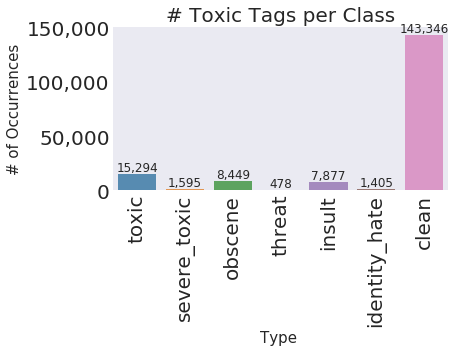

In [8]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(6,3))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# Toxic Tags per Class", fontsize = 20)
plt.ylabel('# of Occurrences', fontsize=15)
plt.xlabel('Type ', fontsize=15)
ax.tick_params(labelsize = 8)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, '{:,}'.format(int(label)), ha='center', va='bottom', fontsize = 12)

    
ax.tick_params(labelsize = 20)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=90)

plt.show()

* The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
* There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?
    * This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene. 

### Multi-tagging:
Let's check how many comments have multiple tags.

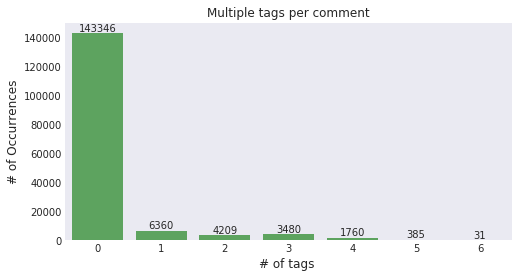

In [9]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(20) that are marked as all of the above!

## Which tags go together?
Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.

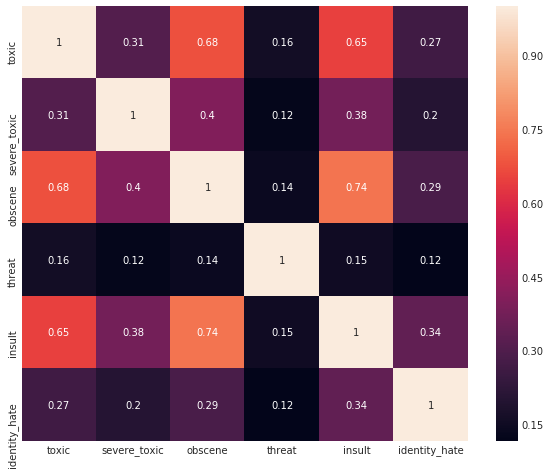

In [10]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like 
* Confusion matrix/Crosstab
* Cramer's V Statistic
    * Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

In [11]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [12]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [13]:
column_header = ["toxic_word", "severe_toxic_word", "obscene_word", "threat_word", "insult_word", "identity_hate_word"]
column = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for i, j in zip(column_header, column):
    temp_df[i] = np.where(temp_df[j] == 1, j+("."), "")
temp_df["combined"] = pd.Series(temp_df[column_header].fillna("").values.tolist()).str.join('')
temp_df["combined"] = temp_df["combined"].replace("", "clean (no_tag)")

In [14]:
temp_df["multilabel"]=temp_df[column].sum(axis=1)
total_multilabels = (temp_df["multilabel"]>=2).sum()
total_multilabels_with_toxic = ((temp_df["multilabel"]>=2) & (temp_df["toxic"]==1)).sum()
print("Total Multilabels:", total_multilabels)
print("Total Multilabels with Toxic:", total_multilabels_with_toxic)
print("Toxic % of Multilabels:", round(total_multilabels_with_toxic/total_multilabels,2))

Total Multilabels: 9865
Total Multilabels with Toxic: 9628
Toxic % of Multilabels: 0.98


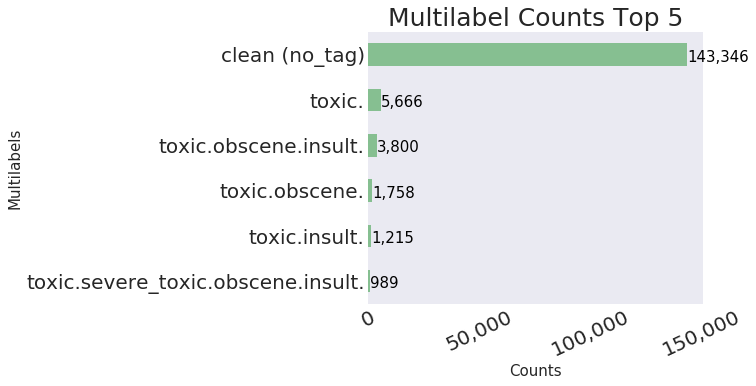

In [15]:
multilabel_summary = pd.DataFrame(temp_df.combined.value_counts())
multilabel_summary.reset_index(inplace=True)
plot = multilabel_summary.iloc[:6,]
ax = plot.sort_values(by="combined").plot(x="index", y="combined", kind="barh", figsize=(6,5), color='#86bf91', legend=False)
ax.set_title('Multilabel Counts Top 5', fontsize = 25)
ax.set_xlabel('Counts', fontsize = 15)
ax.set_ylabel('Multilabels', fontsize = 15)
ax.tick_params(labelsize = 20)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
for i, v in enumerate(plot["combined"].sort_values()):
    ax.text(v+3, i-.15, '{:,}'.format(v), color='black', fontsize = 15)

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes. 

Some interesting observations:

* A Severe toxic comment is always toxic
* Other classes seem to be a subset of toxic barring a few exceptions



In [16]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [17]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614



## Example Comments:

In [18]:
label_index = list(train["comment_text"][train.obscene==1].index)

for i in label_index[:100]:
    print(train.iloc[i, 1])

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
=Tony Sidaway is obviously a fistfuckee. He loves 

In [19]:
toxic_index = list(train[train.comment_text.str.contains("personal attack")]["comment_text"][train.toxic==1].index)
print("toxic:")
for i in toxic_index[:100]:
    print(train.iloc[i, 1])

toxic:
My Band Page's deletion. You thought I was gone. 

Deleting the comment I posted on your 'talk page' does not delete my feelings for your hasty decision to delete my page. You, sir, are still a cock-sucking douche fuck. Sit back for a second and think about what your life has become. ............ Done? That didn't take long did it? Nope. Because, as I am most certainly aware, your life is a shitstorm of sitting in front of the computer masturbating to fictional creatures. Your attempts to get rid of me are mediocre at best. You are constantly sucking the dick of failure. You don't want a personal attack, huh? Well, too bad, Fuckcock McDickerson. You've got one. From me. You can go ahead and delete my profile from wikipedia. I'll just make another one and come right back to 'Syrthiss's talk page and insult the dick off of you. How could you shatter the dreams of an innocent eighteen year old college freshman trying to make a name for his band. Does that make you happy? Fucking wi

My personal attack on you 

Yeah you-I am personally attacking you-regarding the fact that you are ruining Wikipedia with nonsense! ~~TheBlackLarl
HOLY FUCK KNOCK OFF BLOODY THE POLITICALLY CORRECT DUNG 

I can personally attack anyone who doesn't care about Wikipedia enough to get an education before editing. THE STUPID NEED NOT EDIT WIKIPEDIA.

I am a genius and have nearly infinite knowledge. Therefore, I am better. In fact, I am one of Wikipedia's most intelligent editors.  You shouldn't block me; you should be glad to have me.

You should not block me. However, you should block the idiots who don't care about grammar. If you truly care about grammar, you will agree with me. If you don't agree with me or you block me, you are an ignorant fool.

If you disallow my personal attacks on stupid Americans, Wikipedia will fall into the trap of colossal stupidity.
Perhaps the blocking admin will recognise the futility of blocking me from the rest of Wikipedia for what he thought was a pers

In [20]:
train.iloc[44,1]

"I'm Sorry \n\nI'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82"

In [21]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])
#print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [22]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[2,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [23]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])
#print(train[train.obscene==1].iloc[2,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [24]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])
#print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


# Wordclouds - Frequent words:

Image files: https://www.dropbox.com/s/yh9r97rqikmru02/images.zip

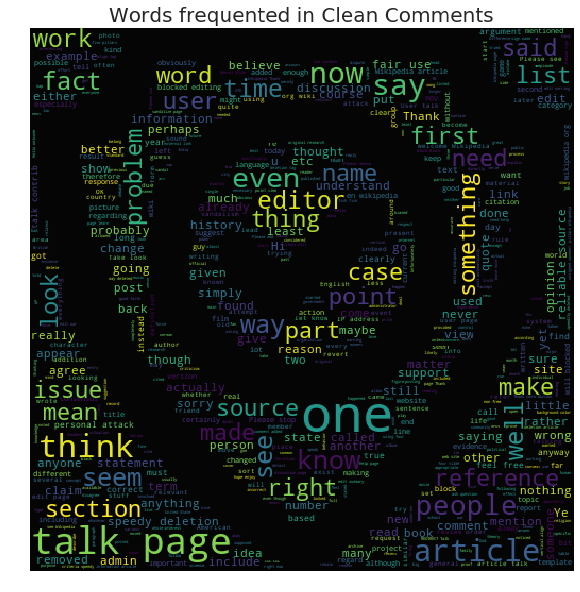

In [26]:
#clean comments
clean_mask=np.array(Image.open("/home/deng_bobby/w266-data/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

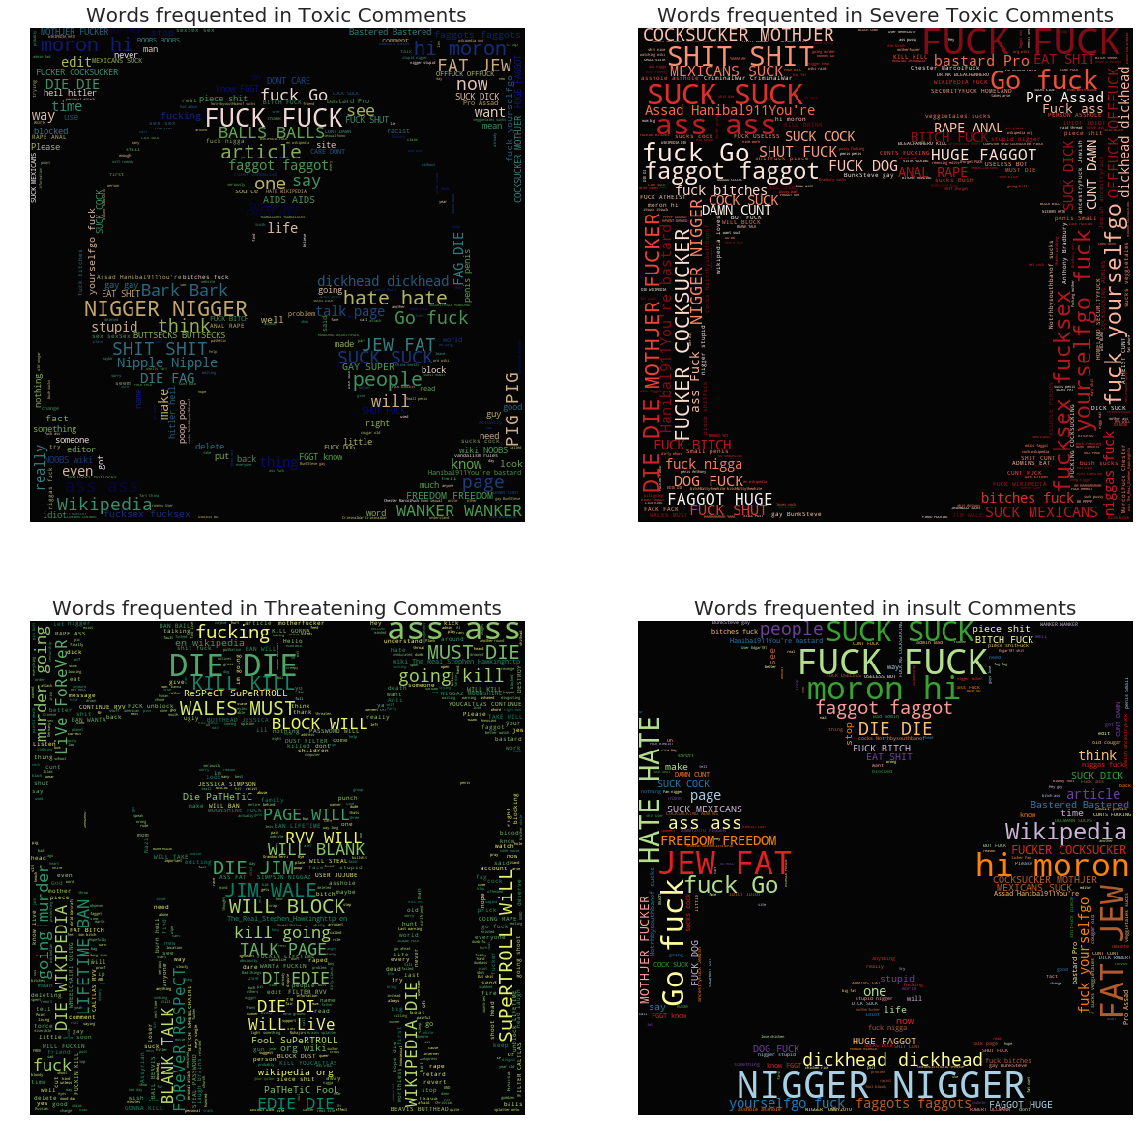

In [27]:
toxic_mask=np.array(Image.open("/home/deng_bobby/w266-data/toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("/home/deng_bobby/w266-data/bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("/home/deng_bobby/w266-data/anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("/home/deng_bobby/w266-data/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()


# Feature engineering:
I've broadly classified my feature engineering ideas into the following three groups
## Direct features:
Features which are a directly due to words/content.We would be exploring the following techniques
* Word frequency features
    * Count features
    * Bigrams
    * Trigrams
* Vector distance mapping of words (Eg: Word2Vec)
* Sentiment scores

## Indirect features:
Some more experimental features.
* count of sentences 
* count of words
* count of unique words
* count of letters 
* count of punctuations
* count of uppercase words/letters
* count of stop words
* Avg length of each word


In [28]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [29]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [30]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [31]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

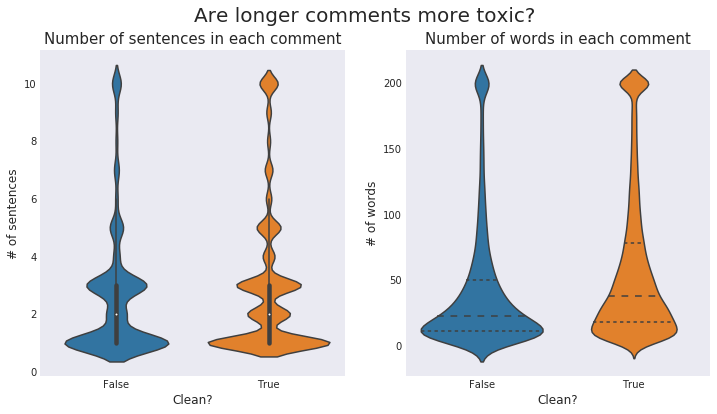

In [32]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

In [33]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

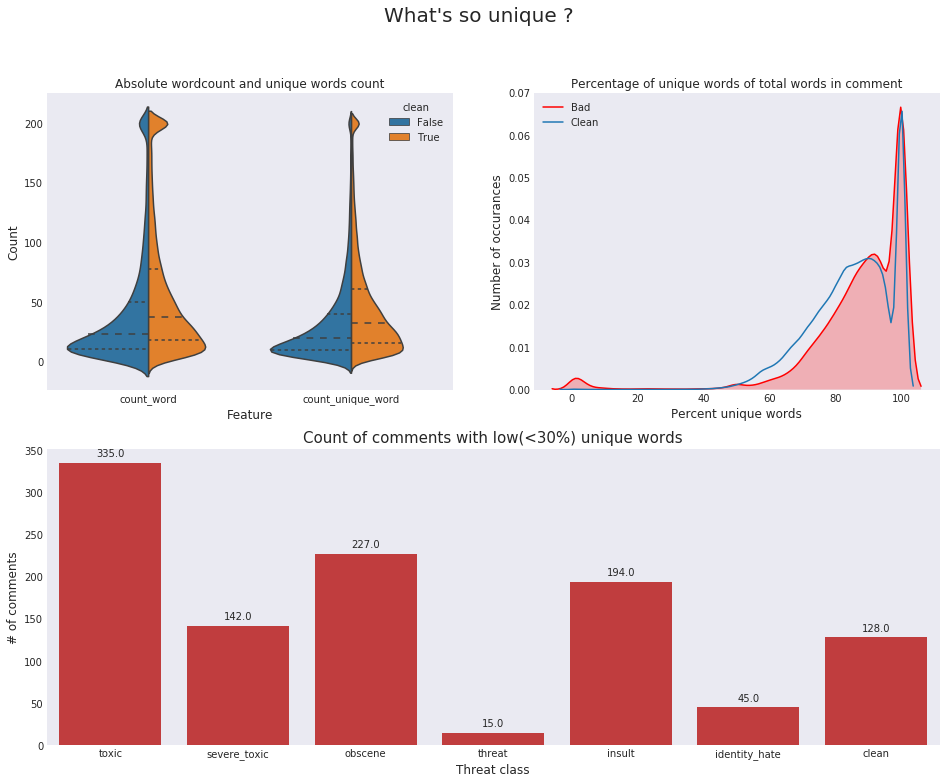

In [34]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

### Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.
   * Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
   
### Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
   * Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments

Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.
# Spammers are more toxic!
No surprises here. Let's take a look at some clean and toxic spam messages

In [35]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

# Spam is toxic to the model too!

These spam entries are bad if we design our model to contain normal word counts features.
Imagine the scenario in which our model picked up the words "mitt romney" from any comment and classified it as toxic :(


# Corpus cleaning:

Its important to use a clean dataset before creating count features. 

In [36]:
corpus=merge.comment_text

In [37]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [38]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    return(clean_sent)

In [39]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [40]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [41]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 275.89375042915344


## Direct features

In [43]:
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [44]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [45]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

end_unigrams=time.time()

print("total time in unigrams",end_unigrams-start_unigrams)
print("total time till unigrams",end_unigrams-start_time)


total time in unigrams 84.65736556053162
total time till unigrams 360.572500705719


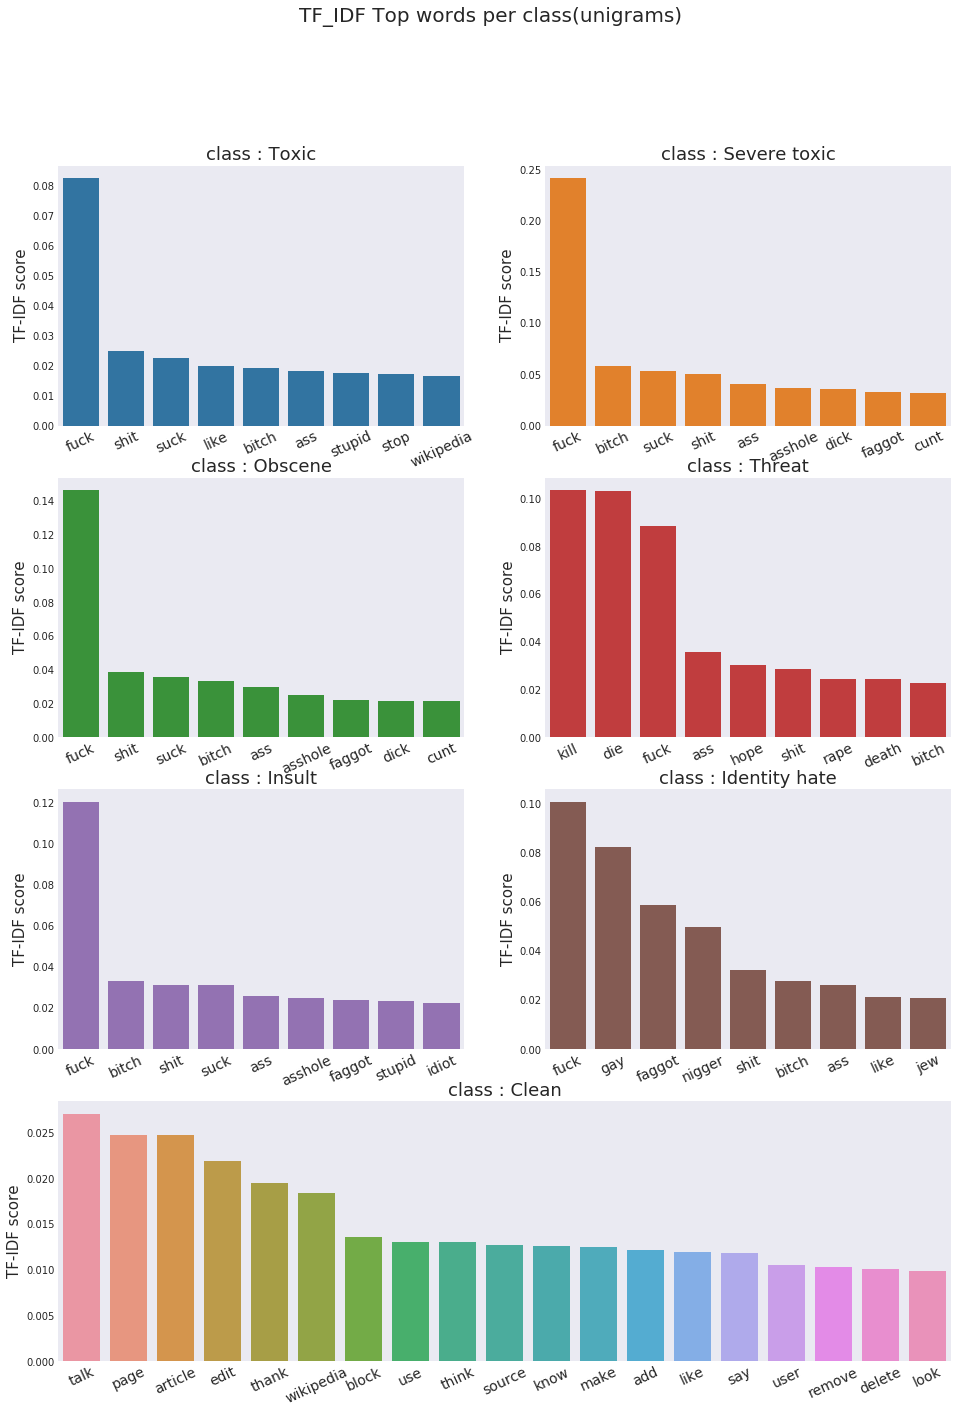

In [46]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=18)
plt.xlabel('', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=15)
plt.xticks(fontsize = 14, rotation = 25)

plt.show()

In [47]:
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

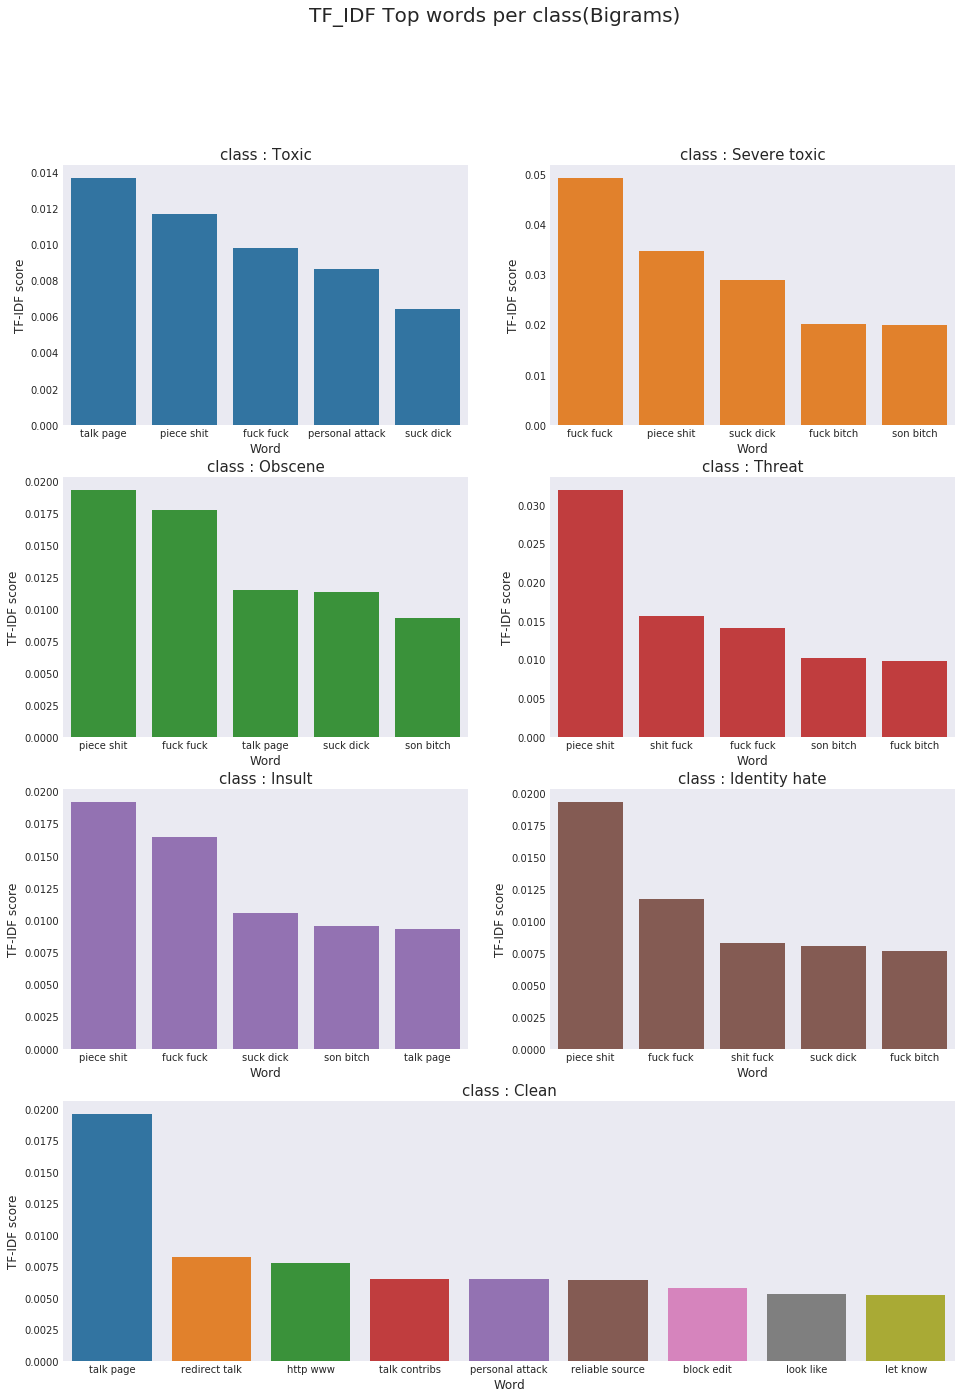

In [48]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [49]:
end_time=time.time()
print("total time till bigrams",end_time-start_time)

total time till bigrams 449.37559938430786


## Sentiment

In [50]:
start_time = time.time()
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid_t = SentimentIntensityAnalyzer()
sentiment_metrics = ['neg', 'neu', 'pos'] #compound metrics produce negative numbers which we can't use
toxic_sentiment_data = pd.DataFrame()
for metrix in sentiment_metrics:
    toxic_sentiment_data['comment_text_'+ metrix] = clean_corpus[:100000].apply(lambda x: sid_t.polarity_scores(x)[metrix])
toxic_sentiment_data['comment_text'] = clean_corpus[:100000]
    
end_time = time.time()
print("Sentiment Analysis took: ", end_time-start_time)

Sentiment Analysis took:  147.78589630126953


In [51]:
toxic_sentiment_data.head(8)

,comment_text_neg,comment_text_neu,comment_text_pos,comment_text
0,0.000,0.850,0.150,explanationwhy edit make username hardcore met...
1,0.000,0.823,0.177,d'aww ! match background colour I am seemingly...
2,0.142,0.749,0.109,"hey man , I am really try edit war . it is guy..."
3,0.076,0.814,0.110,""" morei cannot make real suggestions improveme..."
4,0.000,0.472,0.528,", sir , hero . chance remember page that is ?"
5,0.000,0.270,0.730,""" congratulations well , use tool well . · talk """
6,0.773,0.227,0.000,cocksucker piss around work
7,0.000,0.573,0.427,vandalism matt shirvington article revert . pl...


In [52]:
toxic_sentiment_data = pd.concat([train_tags[:100000], toxic_sentiment_data], axis = 1)
clean = toxic_sentiment_data["clean"]

def success_vs_fail_report(feature, try_log = False):
    print (feature)
    success_values = toxic_sentiment_data[feature][clean]
    print ("SUCCESS", "Mean:", "{:.3f}".format(success_values.mean()), "StdDev:", "{:.3f}".format(success_values.std()))
    fail_values = toxic_sentiment_data[feature][np.logical_not(clean)]
    print ("FAIL   ", "Mean:", "{:.3f}".format(fail_values.mean()), "StdDev:", "{:.3f}".format(fail_values.std()))
    ttest = ttest_ind(fail_values, success_values, equal_var=False)
    print ("TStat:", "{:.3f}\n".format(ttest.statistic))
    
    if try_log:
        ttest_of_log = ttest_ind(np.log(success_values + 1), np.log(fail_values + 1), equal_var=False)
        print ("TStat (log):", "{:.3f}".format(ttest_of_log.statistic))

success_vs_fail_report("comment_text_neg")
success_vs_fail_report("comment_text_pos")
success_vs_fail_report("comment_text_neu")

comment_text_neg
SUCCESS Mean: 0.096 StdDev: 0.131
FAIL    Mean: 0.350 StdDev: 0.246
TStat: 102.400

comment_text_pos
SUCCESS Mean: 0.175 StdDev: 0.164
FAIL    Mean: 0.124 StdDev: 0.141
TStat: -33.863

comment_text_neu
SUCCESS Mean: 0.729 StdDev: 0.190
FAIL    Mean: 0.526 StdDev: 0.229
TStat: -86.322

